In [4]:
import numpy as np 
import matplotlib .pyplot as plt 
import pandas as pd

In [5]:
df = pd.read_csv("dataset\energy_dataset.csv")

In [ ]:
df.info()

In [7]:
import numpy as np

def create_transition_matrix(series, num_states):
    # 1. Discretizar la serie en 'num_states' estados
    bins = np.linspace(min(series), max(series), num_states + 1)
    states = np.digitize(series, bins) - 1  # Restar 1 para que los índices comiencen en 0

    # Asegurarse de que los estados estén en el rango [0, num_states-1]
    states = np.clip(states, 0, num_states - 1)

    # 2. Crear matriz de transición
    trans_matrix = np.zeros((num_states, num_states), dtype=int)
    for i in range(len(states) - 1):
        from_state = states[i]
        to_state = states[i + 1]
        trans_matrix[from_state, to_state] += 1

    # 3. Normalizar filas para obtener probabilidades
    row_sums = trans_matrix.sum(axis=1, keepdims=True)
    trans_matrix = np.divide(trans_matrix, row_sums, where=row_sums != 0)

    return trans_matrix

In [ ]:
# Cargar datos de ejemplo
def load_energy_data():

    return df

# Procesamiento principal
def main():
    # Cargar datos
    df = load_energy_data()
    
    # Seleccionar serie temporal (cambiar según necesidad)
    series = df['generation solar'].values  # o 'total_load_actual'
    series2= df['total load actual'].values
    
    # Crear matriz de transición 8x8
    trans_matrix = create_transition_matrix(series, num_states=8)
    trans_matrix2 = create_transition_matrix(series2, num_states=8)



    # Compute column sums for each transition matrix
    column_sums_1 = trans_matrix.sum(axis=0)  # Column-wise sum for matrix 1
    column_sums_2 = trans_matrix2.sum(axis=0)  # Column-wise sum for matrix 2

    
    # Visualización
    plt.figure(figsize=(10, 8))
    plt.imshow(trans_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Probabilidad')
    plt.title('Matriz de Transición (8 estados)')
    plt.xlabel('Estado siguiente')
    plt.ylabel('Estado actual')
    
    # Mostrar valores en las celdas
    for i in range(trans_matrix.shape[0]):
        for j in range(trans_matrix.shape[1]):
            plt.text(j, i, f"{trans_matrix[i, j]:.2f}", 
                     ha="center", va="center", color="white")
    
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.imshow(trans_matrix2, cmap='viridis', aspect='auto')
    plt.colorbar(label='Probabilidad')
    plt.title('Matriz de Transición (8 estados)')
    plt.xlabel('Estado siguiente')
    plt.ylabel('Estado actual')
    
    # Mostrar valores en las celdas
    for i in range(trans_matrix2.shape[0]):
        for j in range(trans_matrix2.shape[1]):
            plt.text(j, i, f"{trans_matrix2[i, j]:.2f}", 
                     ha="center", va="center", color="white")
    
    plt.show()


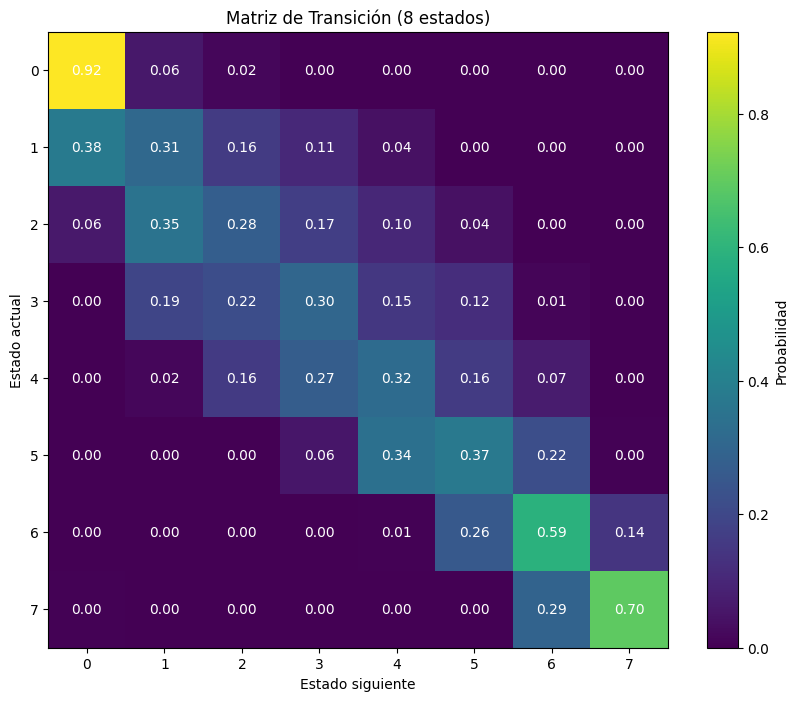

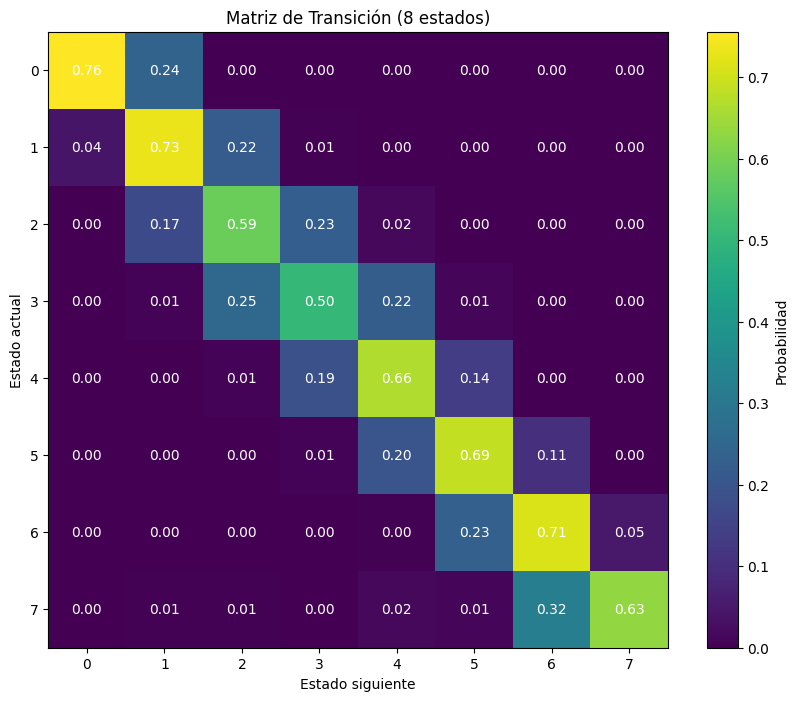

In [9]:

if __name__ == "__main__":
    main()

In [ ]:
import torch
import matplotlib.pyplot as plt

def create_transition_matrix(series, num_states, device='cpu'):
    """
    Create a transition matrix from a time series using PyTorch.
    """
    # Discretize the series into 'num_states' bins
    bins = torch.linspace(series.min(), series.max(), num_states + 1, device=device)
    states = torch.bucketize(series, bins) - 1  # Map to indices starting at 0
    states = torch.clamp(states, 0, num_states - 1)  # Ensure indices are in range

    # Initialize the transition matrix
    trans_matrix = torch.zeros((num_states, num_states), device=device)

    # Populate the transition matrix
    for i in range(len(states) - 1):
        from_state = states[i]
        to_state = states[i + 1]
        trans_matrix[from_state, to_state] += 1

    # Normalize rows to sum to 1
    row_sums = trans_matrix.sum(dim=1, keepdim=True)
    trans_matrix = trans_matrix / row_sums
    
    return trans_matrix

# Load your series (replace with actual data)
generation_solar =  df['generation solar'].values 
total_load_actual =  df['total load actual'].values 
generation_nuclear =  df['generation nuclear'].values 
price_actual = df['price actual'].values 


# Set parameters
num_states = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move series to the device
# Convertir las series de NumPy a tensores de PyTorch
generation_solar = torch.tensor(generation_solar, dtype=torch.float32).to(device)
total_load_actual = torch.tensor(total_load_actual, dtype=torch.float32).to(device)
generation_nuclear = torch.tensor(generation_nuclear, dtype=torch.float32).to(device)
price_actual = torch.tensor(price_actual, dtype=torch.float32).to(device)

# Create transition matrices
transition_matrix_1 = create_transition_matrix(generation_solar, num_states, device)
transition_matrix_2 = create_transition_matrix(total_load_actual, num_states, device)
transition_matrix_3 = create_transition_matrix(generation_nuclear, num_states, device)
transition_matrix_4 = create_transition_matrix(price_actual, num_states, device)

# Compute joint transition matrices
joint_matrix_1_2 = torch.mm(transition_matrix_1, transition_matrix_2)
joint_matrix_3_4 = torch.mm(transition_matrix_3, transition_matrix_4)

# Compute conditional transition matrices
conditional_matrix_1_2 = joint_matrix_1_2 / joint_matrix_1_2.sum(dim=1, keepdim=True)
conditional_matrix_3_4 = joint_matrix_3_4 / joint_matrix_3_4.sum(dim=1, keepdim=True)

# Plot results
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

# Heatmaps for joint matrices
im1 = axes[0, 0].imshow(joint_matrix_1_2.cpu().numpy(), cmap="viridis", aspect="auto")
axes[0, 0].set_title("Joint Matrix 1-2 Heatmap")
fig.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(joint_matrix_3_4.cpu().numpy(), cmap="viridis", aspect="auto")
axes[0, 1].set_title("Joint Matrix 3-4 Heatmap")
fig.colorbar(im2, ax=axes[0, 1])

# Heatmaps for conditional matrices
im3 = axes[1, 0].imshow(conditional_matrix_1_2.cpu().numpy(), cmap="viridis", aspect="auto")
axes[1, 0].set_title("Conditional Matrix 1-2 Heatmap")
fig.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(conditional_matrix_3_4.cpu().numpy(), cmap="viridis", aspect="auto")
axes[1, 1].set_title("Conditional Matrix 3-4 Heatmap")
fig.colorbar(im4, ax=axes[1, 1])

# Eigenvalues
eigenvalues_joint_1_2 = torch.linalg.eigvals(joint_matrix_1_2)
eigenvalues_joint_3_4 = torch.linalg.eigvals(joint_matrix_3_4)

axes[2, 0].bar(range(len(eigenvalues_joint_1_2)), eigenvalues_joint_1_2.real.cpu().numpy(), color="blue", alpha=0.7)
axes[2, 0].set_title("Eigenvalues of Joint Matrix 1-2")
axes[2, 0].set_xlabel("Eigenvalue Index")
axes[2, 0].set_ylabel("Real Part")

axes[2, 1].bar(range(len(eigenvalues_joint_3_4)), eigenvalues_joint_3_4.real.cpu().numpy(), color="green", alpha=0.7)
axes[2, 1].set_title("Eigenvalues of Joint Matrix 3-4")
axes[2, 1].set_xlabel("Eigenvalue Index")
axes[2, 1].set_ylabel("Real Part")

plt.tight_layout()
plt.show()